# 1. Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## If needed unzip dataset

In [3]:
# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset')

# 2. Define Path to Dataset

In [4]:
path = Path('dataset/dataset')
path.ls()

[PosixPath('dataset/dataset/train_x'),
 PosixPath('dataset/dataset/L2_f90e3f4ceeed4884d65a12db9e1f5913__close.jpg'),
 PosixPath('dataset/dataset/test_x'),
 PosixPath('dataset/dataset/test_y_png'),
 PosixPath('dataset/dataset/L2_f0cc415f3d5c1b70b4bed7c6547d42d4__close.jpg'),
 PosixPath('dataset/dataset/train_y_png'),
 PosixPath('dataset/dataset/L2_7652f27d83b8cb794e5235b8cd48e05c_close.jpg'),
 PosixPath('dataset/dataset/L2_8e88b00960cb97b769881bea16597969__close.jpg'),
 PosixPath('dataset/dataset/L2_7652f27d83b8cb794e5235b8cd48e05c__close.jpg'),
 PosixPath('dataset/dataset/L2_f0cc415f3d5c1b70b4bed7c6547d42d4_close.jpg'),
 PosixPath('dataset/dataset/L2_f90e3f4ceeed4884d65a12db9e1f5913_close.jpg'),
 PosixPath('dataset/dataset/test_y'),
 PosixPath('dataset/dataset/train_y'),
 PosixPath('dataset/dataset/test_avg'),
 PosixPath('dataset/dataset/L2_8e88b00960cb97b769881bea16597969_close.jpg'),
 PosixPath('dataset/dataset/train_avg')]

# 3. Define Label and Image Paths

In [5]:
path_lbl = path/'train_y_png'
path_img = path/'train_x'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('dataset/dataset/train_x/L2_a333f21f5bcb85dbbe1545ca4af00ab3.jpg'),
 PosixPath('dataset/dataset/train_x/L2_3f5a2e4a6e774b1d264c3855094976d2.jpg'),
 PosixPath('dataset/dataset/train_x/L2_7d10708ee05ca120f731f5d72a9198ed.jpg')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('dataset/dataset/train_y_png/L6_084f4ac0f4ac205e57f1162b2de9f53c.png'),
 PosixPath('dataset/dataset/train_y_png/L2_989e54bafe3707276fc532ca1965a6ae.png'),
 PosixPath('dataset/dataset/train_y_png/L2_bf6038067f8e5ab3ee0338099df003c3.png')]

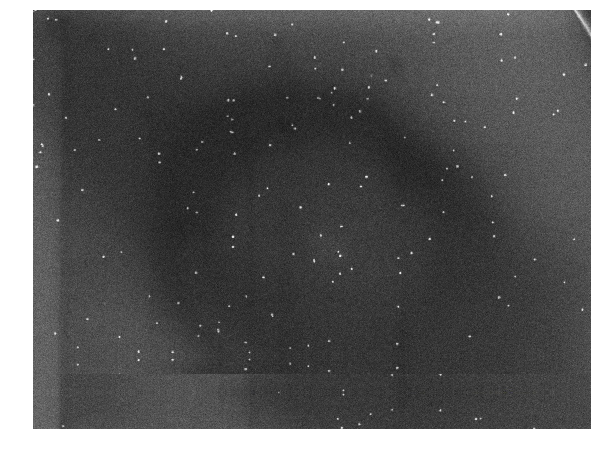

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10, 10))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png' #function to match images with labels

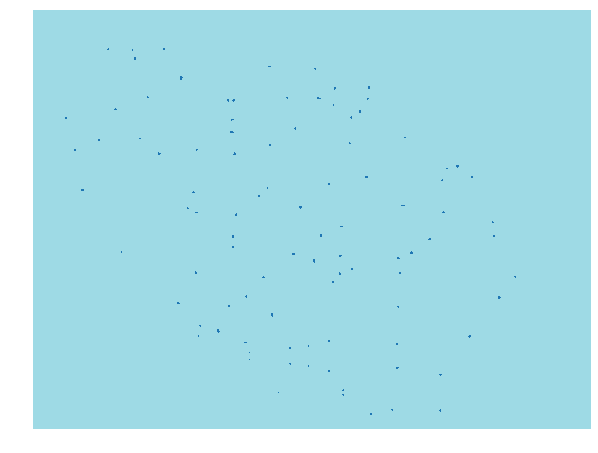

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10, 10), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 768, 1024]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [12]:
codes = np.array(['background', 'particle'], dtype = '<U17'); codes

array(['background', 'particle'], dtype='<U17')

# 4. Create Databunch

In [13]:
size = src_size//4
bs = 8

In [14]:
data = (SegmentationItemList.from_folder(path_img)
          .split_by_rand_pct()
          .label_from_func(get_y_fn, classes=codes)
          .transform(get_transforms(), tfm_y=True, size=size)
          .databunch(bs=bs))

## Show Training Images with Labels Overlaid

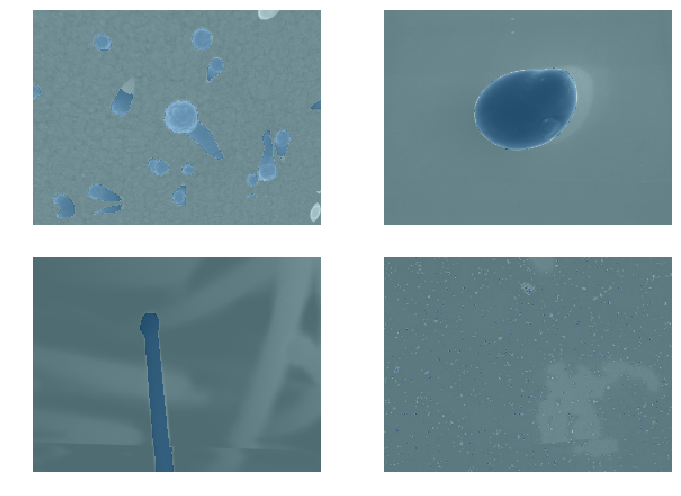

In [15]:
data.show_batch(2, figsize=(10, 7))

# 5. Create Model

In [16]:
learn = unet_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


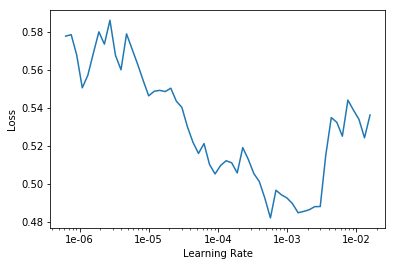

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
lr = 1e-4

In [19]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.437510,0.293667,00:18
1,0.348761,0.192499,00:16
2,0.275981,0.233170,00:16
3,0.229033,0.161942,00:16
4,0.218300,0.180301,00:16
5,0.182119,0.135896,00:16
6,0.165158,0.191149,00:16
7,0.156257,0.133016,00:16
8,0.144785,0.136275,00:16
9,0.137018,0.134235,00:16


In [20]:
learn.save('stage-1')

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


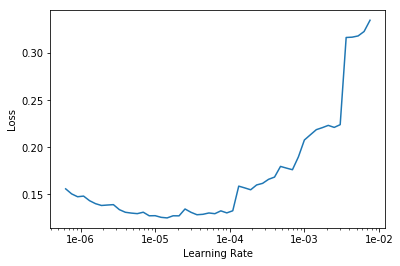

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lrs = slice(5e-5, 1e-4)

In [25]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,time
0,0.118652,0.131975,00:17
1,0.126513,0.136009,00:17
2,0.143285,0.136963,00:17
3,0.148850,0.113957,00:17
4,0.133901,0.118013,00:17
5,0.123190,0.118858,00:17
6,0.113459,0.118983,00:17
7,0.103870,0.105102,00:17
8,0.092651,0.110583,00:17
9,0.089350,0.103811,00:17


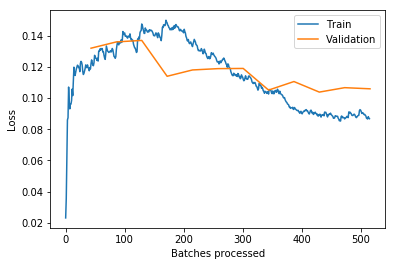

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2')

# 6. Use Bigger Image Sizes in Training

In [13]:
size = src_size//2
bs = 4

In [14]:
data = (SegmentationItemList.from_folder(path_img)
          .split_by_rand_pct()
          .label_from_func(get_y_fn, classes=codes)
          .transform(get_transforms(), tfm_y=True, size=size)
          .databunch(bs=bs))

In [15]:
learn = unet_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


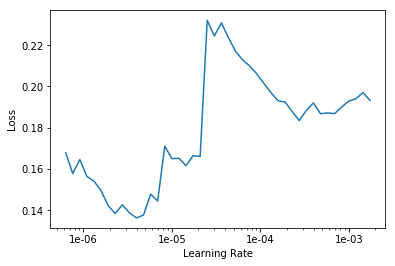

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
lr = 1e-4

In [19]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.158631,0.135210,00:58
1,0.205530,0.240842,00:56
2,0.178086,0.150818,00:56
3,0.162368,0.136391,00:56
4,0.148167,0.121154,00:56
5,0.140196,0.120997,00:56
6,0.116046,0.110511,00:56
7,0.110824,0.122982,00:56
8,0.118247,0.111839,00:56
9,0.109460,0.116084,00:56


In [20]:
learn.save('stage-1-big')

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


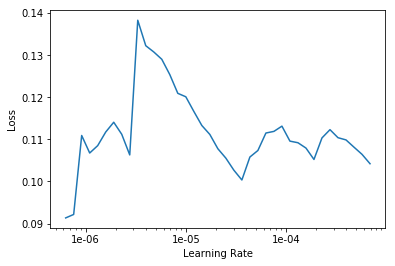

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lrs = slice(5e-5, 1e-4)

In [25]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,time
0,0.149199,0.133443,00:58
1,0.120370,0.108927,00:59
2,0.135123,0.135569,00:59
3,0.131876,0.195169,00:59
4,0.126889,0.165491,00:59
5,0.110651,0.155496,00:59
6,0.100568,0.107329,00:59
7,0.087183,0.121694,00:59
8,0.085349,0.118456,00:59
9,0.073618,0.110697,00:59


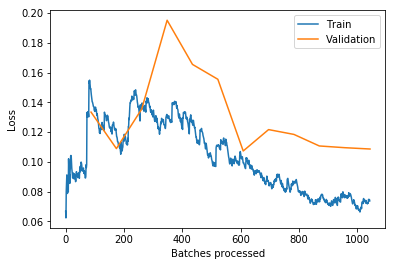

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2-big')

## Show Results

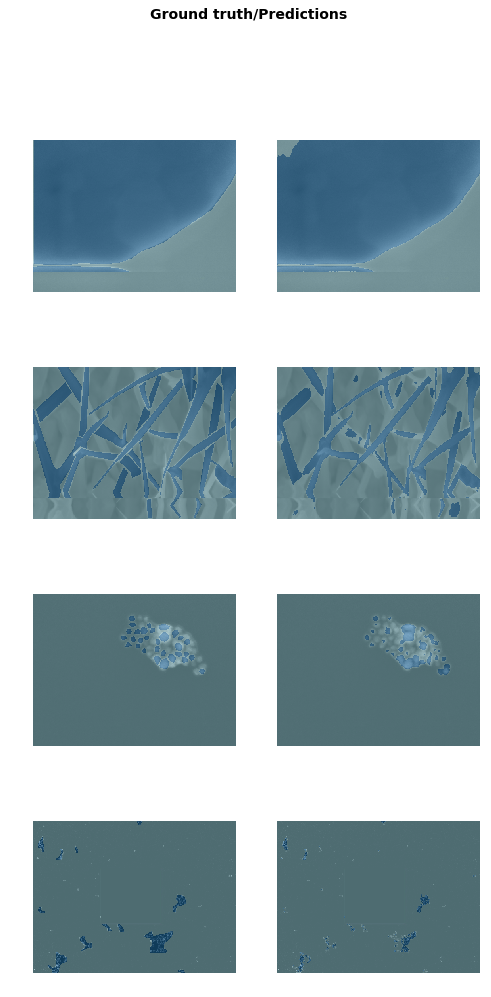

In [29]:
learn.show_results()

# 7. Determine Accuracy wrt Size Distributions (in Progress)

In [35]:
path_test = Path('dataset/dataset/test_x')
file_list = [x for x in path_test.glob('**/*') if x.is_file()]
file = np.random.choice(file_list)

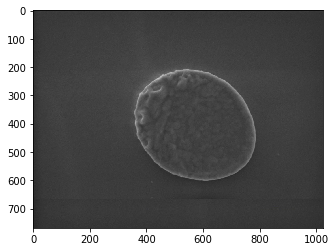

In [37]:
img = mpimg.imread(file)
plt.imshow(img)

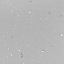

In [51]:
test_data =learn.data.train_ds[1][0]
test_data

In [50]:
pred = learn.predict(test_data)
pred[1]

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

In [ ]:
help(learn.data.train_ds)